In [1]:
import tensorflow as tf
import os
import re
import pandas as pd
import numpy as np
from glob import glob
from numpy import array
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import InceptionV3
import pickle

In [2]:
 # FLICKR8K
DATA_CAP_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
DATA_IMG_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'

# DATA SAVE FOLDERS
CAP_FOLDER = '/'
IMG_FOLDER = '/Flicker8k_Dataset/' 

In [3]:
def download_images():
  # Download caption annotation files
  # It's lightweight.. we can download it everytime :P
  cap_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                        cache_subdir = os.path.abspath('.'),
                                        origin = DATA_CAP_ORIGIN,
                                        extract = True)
  caption_path = os.path.dirname(cap_zip)+CAP_FOLDER+'Flickr8k.token.txt'

  #REMOVE ZIP THING
  os.remove(cap_zip)
    
  if not os.path.exists(os.path.abspath('.') + IMG_FOLDER):
    image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = DATA_IMG_ORIGIN,
                                        extract = True)
    image_path = os.path.dirname(image_zip) + IMG_FOLDER
    
    #REMOVE ZIP THING
    os.remove(image_zip)

  else:
    image_path = os.path.abspath('.') + IMG_FOLDER

  img_lists = []

  # load image lists
  for imgfile in os.listdir(image_path):
    filename = os.fsdecode(imgfile)
    img_lists.append(image_path+filename)

  return caption_path, image_path, img_lists 

In [4]:
#caption_path = os.path.abspath('.') + '/captions.txt'
#image_path = os.path.abspath('.') + '/images/'
caption_path, image_path, img_lists = download_images()
#img_lists = []
 # load image lists
#for imgfile in os.listdir(image_path):
    #filename = os.fsdecode(imgfile)
    #img_lists.append(image_path+filename)

2351104/2340801 [==============================] - 0s 0us/step


In [5]:
caption_path

'c:\\Users\\Kalle\\Desktop\\code\\AI_in3\\Example_Image_Captioning/Flickr8k.token.txt'

In [6]:
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4050955287511914930
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6940786688
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4940782271557219475
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [7]:
image_path

'c:\\Users\\Kalle\\Desktop\\code\\AI_in3\\Example_Image_Captioning/Flicker8k_Dataset/'

In [8]:
img_lists[1]

'c:\\Users\\Kalle\\Desktop\\code\\AI_in3\\Example_Image_Captioning/Flicker8k_Dataset/1001773457_577c3a7d70.jpg'

One example of the dataset :)

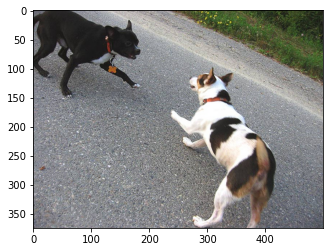

In [9]:
img = mpimg.imread(img_lists[1])
imgplot = plt.imshow(img)
plt.show()

In [10]:
captions = open(caption_path, 'r',  encoding="utf8").read().strip().split('\n')

In [11]:
start = '<start> '
end = ' <end>'

data_map = {}
for line in captions:
    token = line.split()
    image_id = token[0].split('#')[0]
    image_caption = ' '.join(token[1:])
        
    if(image_id not in data_map):
        if os.path.isfile(image_path+image_id):
            data_map[image_id] = list()
    if(image_id in data_map):
        data_map[image_id].append(start + image_caption + end)

print(len(data_map))     
#print(data_map['1989609.jpg'])
#print(data_map['3367399.jpg'])

8091


In [12]:
# Cleanse and pre-process the data

def cleanse_data(data):
    dict = {}
    for key, value in data.items():
        for cap in value: 
            lines = ''
            for i in cap.split():
                #if len(i) < 3:
                    #continue
                i = i.lower()
                lines += i + ' '
            if(key not in dict):
                dict[key] = list()
            
            dict[key].append(lines)
    return dict

data2 = cleanse_data(data_map)
print(len(data2))   
#print(data2['1989609.jpg'])
#print(data2['3367399.jpg']) 
all_images = list(data2.keys())
all_captions = list()
for l in data2.values():
    for s in l:
        all_captions.append(s)


8091


In [13]:
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
print(model.layers[-1].output.shape)
print(model.input.shape)
CNN = tf.keras.models.Model(model.input, model.layers[-1].output)
CNN.trainable = False

(None, 2048)
(None, None, None, 3)


In [14]:
def load_preprocess(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    return img

def encode(image):
    img = load_preprocess(image)
    pred = CNN(img)
    #print(pred.shape)
    pred = np.reshape(pred, pred.shape[1])
    #print(pred.shape)
    return pred

def encode_all(data):
    X = []
    y = []
    for img, desc in tqdm(data.items()):
        img_enc = encode(image_path + img)
        for cap in desc:
            X.append(img_enc)
            y.append(cap)
        
    return X, y

In [15]:
data_X, data_y = encode_all(data2)

100%|██████████| 8091/8091 [09:14<00:00, 14.59it/s]


In [16]:

with open('data_X_enc.txt', 'wb') as fh:
   pickle.dump(data_X, fh)

with open('data_y.txt', 'wb') as p:
   pickle.dump(data_y, p)

In [15]:
pickle_X = open ("data_X_enc.txt", "rb")
images_enc = pickle.load(pickle_X)

pickle_y = open ("data_y.txt", "rb")
text = pickle.load(pickle_y)

print(len(images_enc))
print(len(text))

40455
40455


In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(text)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

token_start = tokenizer.word_index[start.strip()]
token_end = tokenizer.word_index[end.strip()]

all_captions_seq = tokenizer.texts_to_sequences(text)

all_captions_seq = tf.keras.preprocessing.sequence.pad_sequences(all_captions_seq, padding='post')

vocab_size = len(tokenizer.word_index) + 1
max_cap_len = len(all_captions_seq[0])

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(images_enc, all_captions_seq, test_size=0.2)
print(y_train[1])
print(tokenizer.sequences_to_texts([y_train[1]]))
print(y_train[2])
print(tokenizer.sequences_to_texts([y_train[2]]))



[  3  14  27  81  22  57   9  60 382  39   5  49  13 138  83   4   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
['<start> two young girls wearing green and yellow uniforms standing in front of each other <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
[  3   6  10  70  21 167   6 178   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
['<start> the dog jumps to catch the frisbee <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']


In [18]:
def map_func(img_encode, cap):
    x = {'text': cap[0:-1],'image': img_encode}
    y = {'output': cap[1:]}
    
    return x,y

In [19]:
BATCH_SIZE = 64
SHUFFLE_VALUE = 256

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
train_dataset = train_dataset.map(map_func)
valid_dataset = valid_dataset.map(map_func)
train_dataset = train_dataset.shuffle(SHUFFLE_VALUE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(SHUFFLE_VALUE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [71]:
from tensorflow import keras
big = 512
small = 256
dropout = 0.3
#encoder
enc_in = keras.layers.Input(shape=(2048,),name='image')
enc_1 = keras.layers.Dropout(dropout)(enc_in)
enc_2 = keras.layers.Dense(big, activation='relu')(enc_1)
#RNN
dec_in = keras.layers.Input(shape=(None, ), name='text')
dec_1 = keras.layers.Embedding(vocab_size, big, mask_zero=True)(dec_in)
dec_2 = keras.layers.Dropout(dropout)(dec_1)
dec_3 = keras.layers.LSTM(small, return_sequences=True)(dec_2)
dec_4 = keras.layers.Dropout(dropout)(dec_3)
dec_5 = keras.layers.LSTM(big, return_sequences=True)(dec_4)

dec_mix = keras.layers.add([enc_2, dec_5])
dec_out_1 = keras.layers.Dense(big, activation='relu')(dec_mix)
dec_out_2 = keras.layers.Dense(vocab_size, activation='softmax', name='output')(dec_out_1)

model_1 = keras.models.Model(inputs=[enc_in, dec_in], outputs=[dec_out_2])

model_1.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 512)    4350976     ['text[0][0]']                   
                                                                                                  
 dropout_7 (Dropout)            (None, None, 512)    0           ['embedding_2[0][0]']            
                                                                                                  
 image (InputLayer)             [(None, 2048)]       0           []                               
                                                                                            

In [72]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',)

history = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=20, validation_steps=2)

Epoch 1/20
506/506 [==============================] - 27s 43ms/step - loss: 1.7179 - val_loss: 1.5460
Epoch 2/20
506/506 [==============================] - 20s 39ms/step - loss: 1.3362 - val_loss: 1.3067
Epoch 3/20
506/506 [==============================] - 20s 39ms/step - loss: 1.1813 - val_loss: 1.1690
Epoch 4/20
506/506 [==============================] - 20s 40ms/step - loss: 1.1053 - val_loss: 1.1400
Epoch 5/20
506/506 [==============================] - 19s 37ms/step - loss: 1.0474 - val_loss: 1.1244
Epoch 6/20
506/506 [==============================] - 19s 37ms/step - loss: 1.0021 - val_loss: 1.0628
Epoch 7/20
506/506 [==============================] - 19s 38ms/step - loss: 0.9647 - val_loss: 1.0646
Epoch 8/20
506/506 [==============================] - 20s 39ms/step - loss: 0.9330 - val_loss: 1.0001
Epoch 9/20
506/506 [==============================] - 20s 39ms/step - loss: 0.9055 - val_loss: 1.0326
Epoch 10/20
506/506 [==============================] - 19s 37ms/step - loss: 0.880

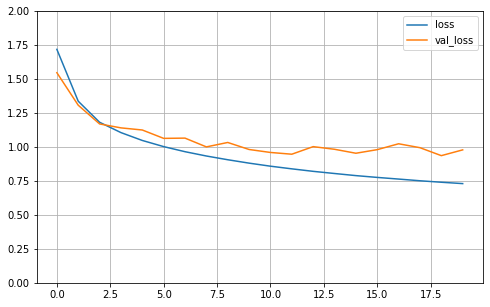

In [73]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()
model_1.save("my_model.h5")

In [74]:
model_1 = tf.keras.models.load_model("my_model.h5")

In [75]:
def generate_caption(image_url):
    image = tf.keras.utils.get_file(origin=image_url)
    encoder_input = encode(image)
    encoder_input = np.expand_dims(encoder_input, axis=0)
    shape = (1, max_cap_len)
    decoder_input = np.zeros(shape=shape, dtype=int)
    token_id = token_start
    output=[]
    count_tokens = 0

    while token_id != token_end and count_tokens < max_cap_len:
        decoder_input[0, count_tokens] = token_id
        input_data ={'text' : decoder_input,'image':encoder_input}
        predict = model_1.predict(input_data)
        token_id = np.argmax(predict[0, count_tokens, :])
        output.append(token_id)
        count_tokens += 1
    
    tokenized = tokenizer.sequences_to_texts([output])
    print('Predicted caption : ', tokenized[0])
    x = mpimg.imread(image)
    x = plt.imshow(x)
    plt.show()

Predicted caption :  a surfer is surfing in the ocean <end>


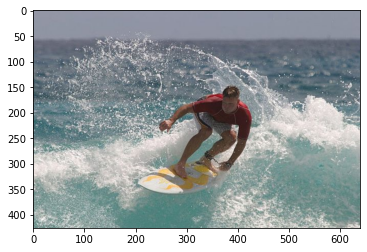

In [76]:
generate_caption('https://tensorflow.org/images/surf.jpg')

Predicted caption :  a small white dog is jumping through a large white room <end>


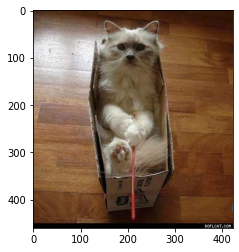

In [77]:

generate_caption('https://i.pinimg.com/originals/05/d5/0b/05d50bdae37f556cf540ab1b456d559b.jpg')


Predicted caption :  a small dog is running through a field <end>


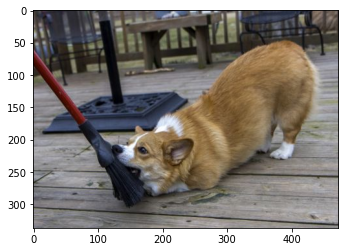

In [78]:
generate_caption('https://i.pinimg.com/474x/6e/76/96/6e7696bd00cfca3ca3c9955b574e626a.jpg')


Predicted caption :  a man in a blue shirt is riding a bike through a forest <end>


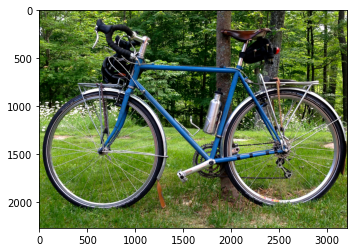

In [79]:
generate_caption('https://images.huffingtonpost.com/2014-07-03-Bike.JPG')


Predicted caption :  a man is sailing in the water <end>


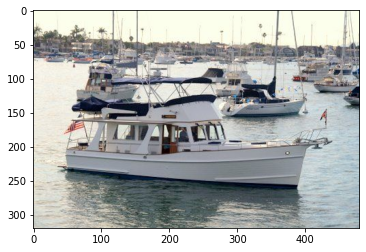

In [80]:

generate_caption('https://i.pinimg.com/originals/99/21/6a/99216aa8f2e9af5d1096796e75c9e510.jpg')


Predicted caption :  a man with a beard and a beard is smiling <end>


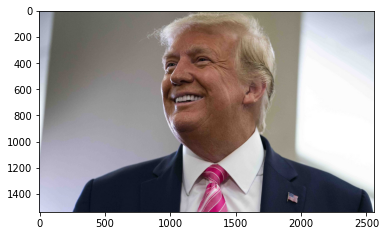

In [81]:
generate_caption('https://www.orissapost.com/wp-content/uploads/2020/11/Donald-Trump-06-scaled.jpg')

Predicted caption :  a man in a white shirt and a white shirt is climbing a rope <end>


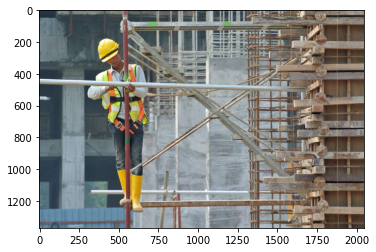

In [82]:
generate_caption('https://www.grutzlaw.com/wp-content/uploads/2018/09/bigstock-124631837-1.jpg')

Predicted caption :  two soccer players are playing soccer <end>


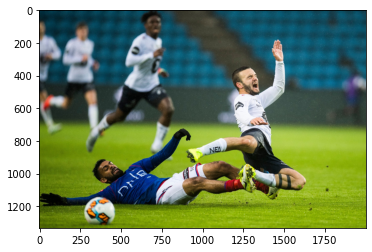

In [83]:
generate_caption('https://g.api.no/obscura/API/dynamic/r1/nadp/tr_2000_2000_s_f/1602476189025/2020/10/12/3424031214/1/original/35061457.jpg?chk=15DF98')

Predicted caption :  a football player in a red uniform is running on a field <end>


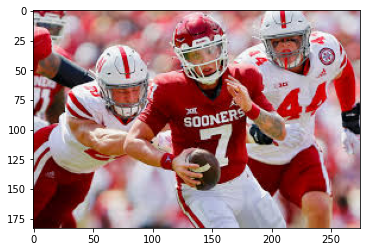

In [84]:
generate_caption('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBSY7Pc7szuZ0HZCa7Cw1_F9RM4bcr8ReVrA&usqp=CAU')

Predicted caption :  a tennis player in a blue shirt hits a tennis ball <end>


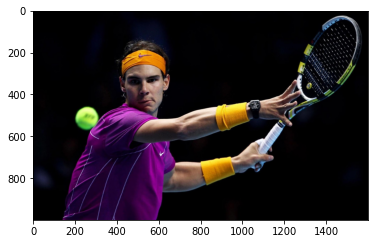

In [85]:
generate_caption('https://3.bp.blogspot.com/-FmKLwGZQcg0/UPdrr8vILUI/AAAAAAAAFbA/xKGxqkTw_70/s1600/Tennis_2013_Wallpaper.2.jpg')

Predicted caption :  a girl in a pink dress and a pink hat is sitting in a park <end>


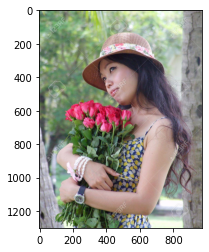

In [86]:
generate_caption('https://previews.123rf.com/images/paisan191/paisan1911401/paisan191140100108/24840186-woman-holding-flowers-bouquet-in-hand-and-smiling.jpg')

Predicted caption :  a basketball player dribbles the ball <end>


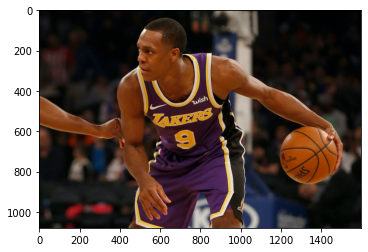

In [87]:
generate_caption('https://celebvogue.com/wp-content/uploads/2019/07/Rajon-Rondo.jpg')

Predicted caption :  a man in a dress is sitting on a wall <end>


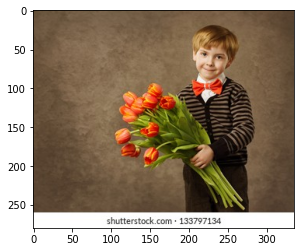

In [88]:
generate_caption('https://image.shutterstock.com/image-photo/child-holding-flowers-bouquet-vintage-260nw-133797134.jpg')

Predicted caption :  a man in a red shirt is sitting on a sidewalk with a red shirt <end>


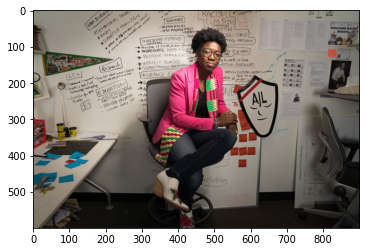

In [89]:
generate_caption('https://cdn10.bostonmagazine.com/wp-content/uploads/sites/2/2018/02/mit-gender-shades-3.jpg')

Predicted caption :  a man in a red jacket is skiing down a snowy hill <end>


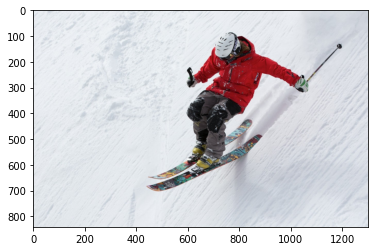

In [90]:
generate_caption('https://montanafit.co/wp-content/uploads/2016/10/downhill-skiier.jpg')

Predicted caption :  a skier skis down a hill <end>


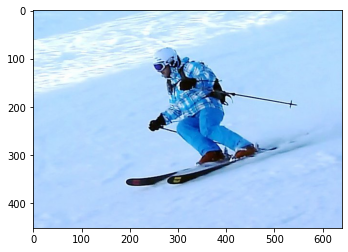

In [91]:
generate_caption('https://www.snow-forecast.com/system/images/9094/large/180575_1705265025804_1063354707_31700754_2042035_n.jpg?1619607177')

Predicted caption :  a snowboarder is skiing down a snowy hill <end>


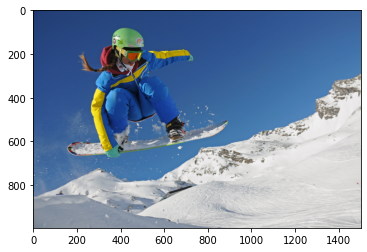

In [92]:
generate_caption('https://www.schischule-kuehtai.at/fileadmin/user_upload/user_upload/DSC_2662.jpg')

Predicted caption :  a man in a black shirt and black shirt is smiling <end>


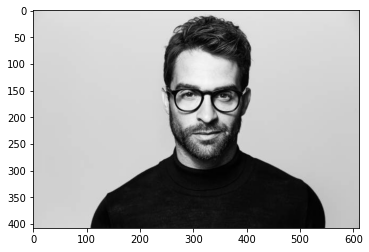

In [93]:
generate_caption('https://media.istockphoto.com/photos/handsome-in-spectacles-picture-id656673020?k=20&m=656673020&s=612x612&w=0&h=kJ5fq_Exi0FG0yw7tqwTdfXuUPBac0o0eH3kSyQyxWs=')

Predicted caption :  a man in a black jacket and black beard is holding a cigarette <end>


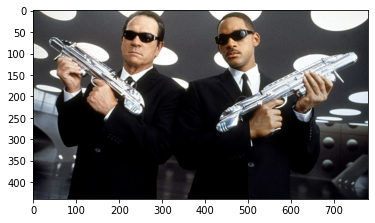

In [94]:
generate_caption('https://d2iltjk184xms5.cloudfront.net/uploads/photo/file/77554/original.jpg')

Predicted caption :  a group of people are playing with a red and white type <end>


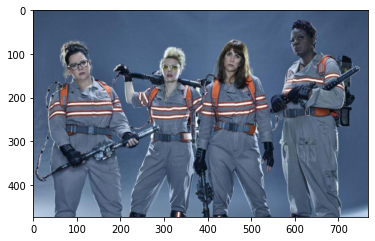

In [95]:
generate_caption('https://i0.wp.com/screengeek.net/wp-content/uploads/2020/05/ghostbusters-2016-768x474.jpg')